# Environment

In [1]:
import higlass
from higlass.client import View, Track, CombinedTrack
from higlass.tilesets import cooler, beddb, chromsizes, bigwig, Tileset
from higlass.viewer import save_b64_image_to_png
from cooler import Cooler

import clodius
import os
import os.path as path
import pandas as pd
import numpy as np
import scipy.stats as stats
import itertools
import negspy.coordinates as nc

import matplotlib.pyplot as plt

def bed2ddb(filepath, uuid=None, **kwargs):
    from clodius.tiles.bed2ddb import get_2d_tileset_info, get_2D_tiles
    from clodius.tiles.utils import tiles_wrapper_2d

    return Tileset(
        uuid=uuid,
        tileset_info=lambda: get_2d_tileset_info(filepath),
        tiles=lambda tids: tiles_wrapper_2d(
            tids, lambda z, x, y: get_2D_tiles(filepath, z, x, y)[(x, y)]
        ),
        **kwargs
    )


# Annotations

In [2]:
annot_dir = path.join("..", "Results", "2019-10-24_higlass")
genes = beddb(path.join(annot_dir, "Data", "hg38", "gene-annotations-hg38.beddb"))
chrom_sizes = chromsizes(path.join(annot_dir, "hg38.chrom.sizes"))
label_font_size = 18
chr_label_size = 30
annots_size = 150

chrom_labels = {
    p: Track(
        track_type=l + "-chromosome-labels",
        tileset=chrom_sizes,
        position=p,
        height=chr_label_size,
        width=chr_label_size,
        options={
            "fontSize": label_font_size,
            "showMousePosition": True,
        },
    ) for p, l in zip(["top", "bottom", "left", "right"], ["horizontal", "horizontal", "vertical", "vertical"])
}
chrom_grid = {
    p: Track(
        track_type=l + "-chromosome-grid",
        tileset=chrom_sizes,
        position=p,
        height=chr_label_size,
        width=chr_label_size,
        options={
            "fontSize": label_font_size,
            "showMousePosition": True,
        },
    ) for p, l in zip(
        ["top", "bottom", "left", "right"],
        ["horizontal", "horizontal", "vertical", "vertical"])
}

gene_annots = {
    p: Track(
        track_type=l + "-gene-annotations",
        tileset=genes,
        position=p,
        height=annots_size,
        width=annots_size,
        options={
            "fontSize": label_font_size,
            "showMousePosition": True,
        },
    ) for p, l in zip(["top", "bottom", "left", "right"], ["horizontal", "horizontal", "vertical", "vertical"])
}

hg38 = nc.get_chrominfo("hg38")

# Load data

## Metadata

In [3]:
meta = pd.read_csv("config.tsv", sep="\t")
meta = meta.loc[meta.Include == "Yes", :]

SAMPLES = {
    "all": meta["Sample_ID"].tolist(),
    "tumour": meta.loc[(meta.Source == "Primary") & (meta.Type == "Malignant"), "Sample_ID"].tolist(),
    "benign": meta.loc[(meta.Source == "Primary") & (meta.Type == "Benign"), "Sample_ID"].tolist(),
    "primary": meta.loc[(meta.Source == "Primary"), "Sample_ID"].tolist(),
    "clines": meta.loc[(meta.Source == "Cell Line"), "Sample_ID"].tolist(),
}
meta

,Sample_ID,Label,Include,Source,Type,Sample_Colour,Type_Colour,Tissue,T2E
0,PCa13266,CPCG0268,Yes,Primary,Malignant,#7F3C8D,#1F77B4,Prostate,No
1,PCa13848,CPCG0366,Yes,Primary,Malignant,#11A579,#1F77B4,Prostate,Yes
2,PCa14121,CPCG0255,Yes,Primary,Malignant,#3969AC,#1F77B4,Prostate,No
3,PCa19121,CPCG0258,Yes,Primary,Malignant,#F2B701,#1F77B4,Prostate,Yes
4,PCa3023,CPCG0324,Yes,Primary,Malignant,#E73F74,#1F77B4,Prostate,Yes
5,PCa33173,CPCG0246,Yes,Primary,Malignant,#80BA5A,#1F77B4,Prostate,No
6,PCa40507,CPCG0342,Yes,Primary,Malignant,#E68310,#1F77B4,Prostate,Yes
7,PCa51852,CPCG0336,Yes,Primary,Malignant,#008695,#1F77B4,Prostate,Yes
8,PCa53687,CPCG0339,Yes,Primary,Malignant,#CF1C90,#1F77B4,Prostate,No
9,PCa56413,CPCG0331,Yes,Primary,Malignant,#F97B72,#1F77B4,Prostate,Yes


## Contact matrices

In [4]:
resolutions = [
    1000, 2000, 3000, 4000, 5000,
    10000, 20000, 30000, 40000, 50000,
    100000, 200000, 300000, 400000, 500000,
    1000000, 2000000, 3000000, 4000000, 5000000
][::-1]
min_resolution = 20000
colour_range = [
    "rgba(65, 105, 225, 1.0)",
    "rgba(255, 250, 250, 1.0)",
    "rgba(255, 25, 25, 1.0)"
]

mtx_dir = {
    "primary": path.join("..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts"),
    "clines": path.join("..", "..", "Data", "External", "Rhie_2019", "Contacts"),
}
mtx_files = {}
for s in SAMPLES["primary"]:
    mtx_files[s] = path.join(mtx_dir["primary"], s + ".mcool")

for s in SAMPLES["clines"]:
    mtx_files[s] = path.join(mtx_dir["clines"], s + ".mcool")

mtx_tilesets = {
    s: cooler(f)
    for s, f in mtx_files.items()
}

contacts = {
    s: {
        p: Track(
            track_type=pl + "heatmap",
            datatype="matrix",
            filetype="cooler",
            tileset=mtx_tilesets[s],
            height=height,
            options={
                "maxZoom": str(resolutions.index(min_resolution)),
                "colorbarPosition": "topRight",
                "showMousePosition": True,
                "name": meta.loc[meta["Sample_ID"] == s, "Label"].values[0],
                "colorRange": colour_range,
            }
        )
        for p, pl, height in zip(
            ["top", "right", "bottom", "left", "center"],
            ["horizontal-", "horizontal-", "horizontal-", "horizontal-", ""],
            #["linear-", "linear-", "linear-", "linear-", ""],
            [120, 120, 120, 120, 480],
        )
    }
    for s in mtx_files.keys()
}

## H3K27ac ChIP-seq

In [5]:
chip_track_dir = path.join("..", "Data", "Processed", "2019-05-03_PCa-H3K27ac-peaks", "Tracks")

chip_files = {
    "signal": {
        s: path.join(chip_track_dir, "Pca" + s[3:] + "_FE.sorted.filtered.bw")
        for s in SAMPLES["tumour"]
    },
    "peaks": {
        s: path.join(chip_track_dir, "Pca" + s[3:] + "_peaks.beddb")
        for s in SAMPLES["tumour"]
    },
    "cores": {
        s: path.join(chip_track_dir, s + ".cores.beddb")
        for s in SAMPLES["tumour"]
    },
}
    
chip_tilesets = {
    "signal": {
        s: bigwig(f)
        for s, f in chip_files["signal"].items()
    },
    "peaks": {
        s: beddb(f)
        for s, f in chip_files["peaks"].items()
    },
    "cores": {
        s: beddb(f)
        for s, f in chip_files["cores"].items()
    },
}

line_height = 150

chip = {
    "signal": {
        s: {
            p: Track(
                track_type=t + "line",
                position=p,
                tileset=ts,
                filetype="vector",
                height=line_height,
                width=line_height,
                options={
                    "showMousePosition": True,
                    "name": meta.loc[meta["Sample_ID"] == s, "Label"].values[0] + " H3K27ac",
                    "lineStrokeColor": meta.loc[meta["Sample_ID"] == s, "Sample_Colour"].values[0],
                },
            )
            for p, t in zip(
                ["top", "bottom", "left", "right"],
                ["horizontal-", "horizontal-", "vertical-", "vertical-"],
            )
        }
        for s, ts in chip_tilesets["signal"].items()
    },
    "peaks": {
        s: {
            p: Track(
                track_type=t + "bedlike",
                position=p,
                tileset=ts,
                filetype="beddb",
                options={
                    "showMousePosition": True,
                    "name": meta.loc[meta["Sample_ID"] == s, "Label"].values[0] + " H3K27ac",
                    "fillColor": meta.loc[meta["Sample_ID"] == s, "Sample_Colour"].values[0],
                },
            )
            for p, t in zip(
                ["top", "bottom", "left", "right"],
                ["", "", "vertical-", "vertical-"],
            )
        }
        for s, ts in chip_tilesets["peaks"].items()
    },
    "cores": {
        s: {
            p: Track(
                track_type=t + "bedlike",
                position=p,
                tileset=ts,
                filetype="beddb",
                options={
                    "showMousePosition": True,
                    "name": meta.loc[meta["Sample_ID"] == s, "Label"].values[0] + " H3K27ac",
                    "fillColor": meta.loc[meta["Sample_ID"] == s, "Sample_Colour"].values[0],
                },
            )
            for p, t in zip(
                ["top", "bottom", "left", "right"],
                ["", "", "vertical-", "vertical-"],
            )
        }
        for s, ts in chip_tilesets["cores"].items()
    },
}

# Figures

## _BRAF_ translocation

### Contact matrix

In [10]:
views = [View(
    tracks=[
        chrom_labels["top"],
        chrom_grid["top"],
        gene_annots["top"],
        chrom_labels["left"],
        chrom_grid["left"],
        gene_annots["left"],
        contacts["PCa53687"]["center"],
    ],
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr7", 140500000, hg38),
        nc.chr_pos_to_genome_pos("chr7", 141500000, hg38)
    ],
    initialYDomain=[
        nc.chr_pos_to_genome_pos("chr19", 15600000, hg38),
        nc.chr_pos_to_genome_pos("chr19", 16200000, hg38)
    ],
)]

d, s, v = higlass.display(
    views=views,
    server_port=8192,
    zoom_syncs=[views],
    location_syncs=[views],
)
d

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'WXi8SqZKTZCmJWQ73LFHUg', 'tracks': {'top': [{'ty…

### Virtual 4C with _BRAF_ promoter

In [6]:
sv_sample_id = "PCa53687"
res = 20000

# contact matrices loaded as cooler file objects
coolers = {
    s: Cooler(mtx_files[s] + "::/resolutions/" + str(res))
    for s in SAMPLES["tumour"]
}

# coordinates of the encompassing TADs
i_tad = [140480000, 141500000]
j_tad = [14639975, 17040000]
i_start, i_stop = coolers[sv_sample_id].extent("chr7:" + str(i_tad[0]) + "-" + str(i_tad[1]))
j_start, j_stop = coolers[sv_sample_id].extent("chr19:" + str(j_tad[0]) + "-" + str(j_tad[1]))

# coordinates of the gene and structural variant
braf_coords = [140719327, 140924928]
sv_coords = [140760000, 15919000]

# other relevant coordinates
braf_prom_coords = [braf_coords[1] - 500, braf_coords[1] + 1500]
braf_new_coords = [braf_coords[0], sv_coords[0]]
braf_orig_coords = [sv_coords[0], braf_coords[1]]
braf_start, braf_stop = coolers[sv_sample_id].extent("chr7:" + str(braf_coords[0]) + "-" + str(braf_coords[1]))
braf_prom_start, braf_prom_stop = coolers[sv_sample_id].extent("chr7:" + str(braf_prom_coords[0]) + "-" + str(braf_prom_coords[1]))
braf_new_start, braf_new_stop = coolers[sv_sample_id].extent("chr7:" + str(braf_new_coords[0]) + "-" + str(braf_new_coords[1]))
braf_orig_start, braf_orig_stop = coolers[sv_sample_id].extent("chr7:" + str(braf_orig_coords[0]) + "-" + str(braf_orig_coords[1]))

dennd2a_coords = [140518420, 140673993]
dennd2a_start, dennd2a_stop = coolers[sv_sample_id].extent("chr7:" + str(dennd2a_coords[0]) + "-" + str(dennd2a_coords[1]))

# subset the contact matrices to just the relevant locations
mat = {
    s : {
        "BRAF_whole": {
            "old": coolers[s].matrix()[i_start:i_stop, braf_start:braf_stop],
            "new": coolers[s].matrix()[j_start:j_stop, braf_start:braf_stop],
        },
        "BRAF_new": {
            "old": coolers[s].matrix()[i_start:i_stop, braf_new_start:braf_new_stop],
            "new": coolers[s].matrix()[j_start:j_stop, braf_new_start:braf_new_stop],
        },
        "BRAF_orig": {
            "old": coolers[s].matrix()[i_start:i_stop, braf_orig_start:braf_orig_stop],
            "new": coolers[s].matrix()[j_start:j_stop, braf_orig_start:braf_orig_stop],
        },
        "BRAF_prom": {
            "old": coolers[s].matrix()[i_start:i_stop, braf_prom_start:braf_prom_stop],
            "new": coolers[s].matrix()[j_start:j_stop, braf_prom_start:braf_prom_stop],
        },
        "DENND2A": {
            "old": coolers[s].matrix()[i_start:i_stop, dennd2a_start:dennd2a_stop],
            "new": coolers[s].matrix()[j_start:j_stop, dennd2a_start:dennd2a_stop],
        },
        "locus": coolers[s].matrix()[j_start:j_stop, i_start:i_stop],
    } for s in SAMPLES["tumour"]
}

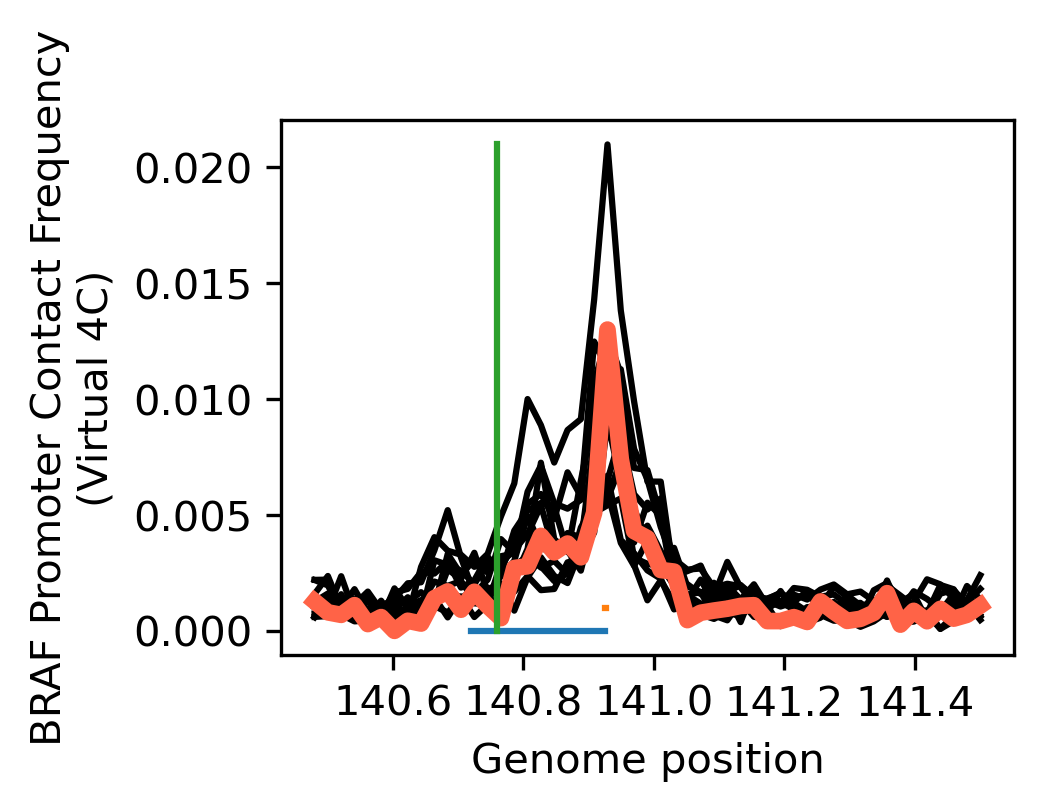

In [10]:
# create figure object
fig= plt.figure(
    figsize=(8 / 2.54, 6 / 2.54),
    dpi=300,
)

# what part of the BRAF gene, and what location are we plotting
which_braf = "BRAF_prom"
which_location = "old"

# add a black line for each sample that is not the mutated one
for s in SAMPLES["tumour"]:
    if s != sv_sample_id:
        plt.plot(
            np.linspace(
                i_tad[0],
                i_tad[1],
                mat[s][which_braf][which_location].shape[0]
            ),
            np.mean(
                mat[s][which_braf][which_location],
                axis=1
            ),
            color="#000000",
        )

# add the line for the mutated sample, but make it bright
plt.plot(
    np.linspace(
        i_tad[0],
        i_tad[1],
        mat[sv_sample_id][which_braf][which_location].shape[0]
    ),
    np.mean(
        mat[sv_sample_id][which_braf][which_location],
        axis=1
    ),
    color="#ff6347",
    linewidth=4,
)

# add an annotation line for the BRAF gene so we can line it up to the annotation later
plt.plot(
    np.linspace(braf_coords[0], braf_coords[1], 2),
    [0, 0],
)

# add an annotation line for the BRAF promoter so we can highlight the anchor for the Virtual 4C analysis
plt.plot(
    np.linspace(braf_prom_coords[0], braf_prom_coords[1], 2),
    [0.001, 0.001],
)

# add a vertical line highlighting where the structural variant bounds are
plt.plot(
    [sv_coords[0], sv_coords[0]],
    [
        0,
        np.nanmax([
            np.nanmean(mat[s][which_braf][which_location], axis=1)
            for s in SAMPLES["tumour"]
        ])
    ],
)

# add x-axis ticks to help line it up to the annotation, later
plt.xticks(
    ticks=[140.6e6, 140.8e6, 141.0e6, 141.2e6, 141.4e6],
    labels=[140.6, 140.8, 141.0, 141.2, 141.4]
)

# add axis labels
plt.xlabel("Genome position")
plt.ylabel("BRAF Promoter Contact Frequency\n(Virtual 4C)")

# save plot
fig.savefig(
    path.join("..", "Results", "2020-08-11_novel-cores", "BRAF-4C-promoter.pdf")
)
plt.close()

fig

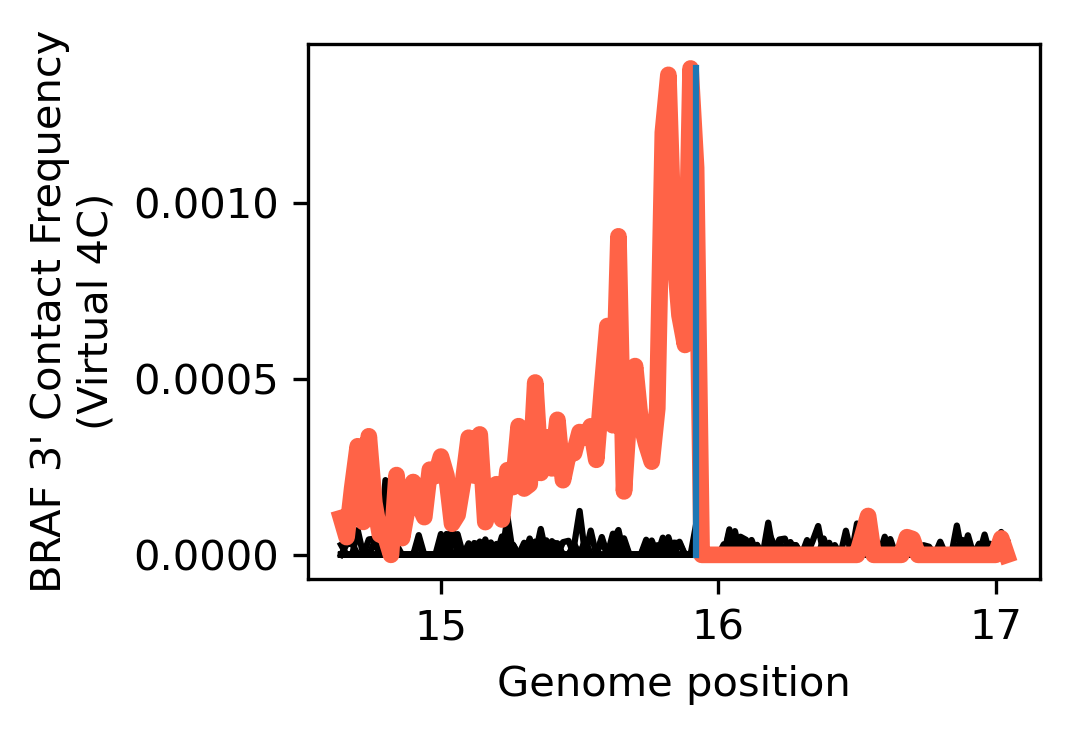

In [14]:
# make a new figure
fig= plt.figure(
    figsize=(8 / 2.54, 6 / 2.54),
    dpi=300,
)

# what part of the BRAF gene, and what location are we plotting
which_braf = "BRAF_new"
which_location = "new"

# add a black line for each sample that is not the mutated one
for s in SAMPLES["tumour"]:
    if s != sv_sample_id:
        plt.plot(
            np.linspace(
                j_tad[0],
                j_tad[1],
                mat[s][which_braf][which_location].shape[0]
            ),
            np.mean(
                mat[s][which_braf][which_location],
                axis=1
            ),
            color="#000000",
        )

# add an annotation line for the BRAF gene so we can line it up to the annotation later
plt.plot(
    np.linspace(
        j_tad[0],
        j_tad[1],
        mat[sv_sample_id][which_braf][which_location].shape[0]
    ),
    np.mean(
        mat[sv_sample_id][which_braf][which_location],
        axis=1
    ),
    color="#ff6347",
    linewidth=4,
)

# add a vertical line highlighting where the structural variant bounds are
plt.plot(
    [sv_coords[1], sv_coords[1]],
    [
        0,
        np.nanmax([
            np.nanmean(
                mat[s][which_braf][which_location],
                axis=1
            )
            for s in SAMPLES["tumour"]
        ])
    ],
)

# add axis labels
plt.xlabel("Genome position")
plt.ylabel("BRAF 3' Contact Frequency\n(Virtual 4C)")

# add x-axis ticks to help line it up to the annotation, later
plt.xticks(
    ticks=[1.5e7, 1.6e7, 1.7e7],
    labels=[15, 16, 17]
)

# save plot
fig.savefig(
    path.join("..", "Results", "2020-08-11_novel-cores", "BRAF-4C-new.pdf")
)
plt.close()

fig

## T2E fusion

### Contact matrix

In [ ]:
pos = [
    nc.chr_pos_to_genome_pos("chr21", 38350000, hg38),
    nc.chr_pos_to_genome_pos("chr21", 38700000, hg38),
]

comb_tracks = {
    "chip": {
        "mut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s in t2e_samples]),
        "nonmut": CombinedTrack([chip[s]["top"] for s in tumour_samples if s in nont2e_samples]),
    },
    "peak": {
        "mut": CombinedTrack([peaks[s]["top"] for s in tumour_samples if s in t2e_samples]),
        "nonmut": CombinedTrack([peaks[s]["top"] for s in tumour_samples if s in nont2e_samples]),
    },
    "core": {
        "mut": CombinedTrack([cores[s]["top"] for s in tumour_samples if s in t2e_samples]),
        "nonmut": CombinedTrack([cores[s]["top"] for s in tumour_samples if s in nont2e_samples]),
    },
}

# views
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            comb_tracks["chip"]["mut"],
        ] + [
            peaks[s]["top"] for s in t2e_samples
        ] + [
            comb_tracks["chip"]["nonmut"],
        ] + [
            peaks[s]["top"] for s in nont2e_samples
        ],
        initialXDomain=pos,
    )
]

display, server, viewconf = higlass.display(
    views=v,
    value_scale_syncs=[
        [(v[0], chip[s]["top"]) for s in tumour_samples],
    ],
    server_port=8195
)

display